In [1]:
import pandas as pd
from pprint import pprint as pp
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import metrics
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, learning_curve
import sys
from __future__ import division
sys.path.insert(0, "/media/diskD/EPFL/Fall 2016/ADA/Homework/Gokcen_Meryem_Riyadh_ADA/04 - Applied ML")
reload(sys)
from HelperFunctions import *
warnings.filterwarnings('ignore')

# I. Prediction of Skin Color of Players

In this first task, we are asked to train random forest model that predicts the racial class of the players based on a set of features. Before trying any model and playing with parameters, we start by exploring the data and pre-processing and making several assumptions about the features which we validate by looking at features importance. We explain our rational behind model evaluation and we compare the different results we got in both binary and multi-class classification.   

# 1. Exploratory Data Analysis

## 1.1. Data Cleaning and Pre-Processing

In [2]:
# Importing the data
crowdstorming_df = pd.read_csv('Data/CrowdstormingDataJuly1st.csv')
# Checking the first 5 rows
crowdstorming_df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [3]:
crowdstorming_df.shape

(146028, 28)

Before doing any pre-processing and cleaning, the data consists in a total of 146028 player-referee dyads. 

### Handling NaN Cases: 

We will start by checking for columns for which there are NaN values. 

In [4]:
crowdstorming_df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID           True
rater1            True
rater2            True
refNum           False
refCountry       False
Alpha_3           True
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
dtype: bool

From the description, we can conclude the following:
* There are missing values on rater1, rater2 and photoID and since our goal is to build a classifier based on those labels we decided to drop rows with nan values for those columns. 
* There are missing values in height, weight. A tentative solution is to replace those values by average heights and weights of people who belong to the same leagueCountry or people with same position (for e.g: goalkeeper is usually taller), but it is safe to do it and we don't have a lot of missing values. So, we decided to drop them.
* There are missing values for Alpha_3, meanIAT, nIAT, seIAT, meanExp, nExp, seExp. Those we also decided to drop.

In [5]:
crowdstorming_df = crowdstorming_df.dropna()

In [6]:
len(crowdstorming_df)

115457

In [7]:
(len(crowdstorming_df)/146028) * 100

79.0649738406333

After removing rows with at least one NaN value, we keep 115457 players in total which is roughly 80% of the data.

## 1.2. Aggregating player-referee information by player

In [8]:
counts = []
for player in range(0,len(list(set(crowdstorming_df['player'])))):
    pp("player:"+str(player)+"playerShort:"+str(crowdstorming_df[crowdstorming_df['player']==player]['playerShort']))

So there are more instances of playerShort than there is for player since there are some players that have the same player name with different values of playerShort. We decided to aggregate by playerShort since it is unique. 

We proceed now with the aggregation by playerShort in the following way:
* We pick the first element in club, leagueCountry, birthday, weight, height, photoID, position, refNum, refCountry, since we think there is one to one mapping between playershort and all those columns
* We take the sum to get number of games, victories, ties, defeats, goals, yellowCards, yellowReds, redCards.
* We take the mean to get the average of meanIAT, nIAT, seIAT, meanExp, nExp, seExp, rater1, rater2.

In [9]:
f = {'club':'first',
     'leagueCountry':'first',
     'birthday':'first',
     'height':'first', 
     'weight':'first',
     'games': 'sum', 
     'victories':'sum',
     'ties': 'sum',
     'defeats': 'sum', 
     'goals': 'sum', 
     'yellowCards': 'sum', 
     'yellowReds': 'sum', 
     'redCards': 'sum',
     'photoID':'first',
     'position':'first',
     'refNum':'first',
     'refCountry':'first',
     'Alpha_3':'first',
     'meanIAT':'mean',
     'nIAT':'mean', 
     'seIAT':'mean',
     'meanExp': 'mean',
     'nExp':'mean', 
     'seExp':'mean',
     'rater1':'mean',
     'rater2':'mean'
    }
crowdstorming_df_player_agg = crowdstorming_df.groupby(['playerShort']).agg(f)

In [10]:
crowdstorming_df_player_agg.head()

,weight,nExp,height,meanExp,rater2,yellowReds,leagueCountry,rater1,club,victories,...,goals,ties,defeats,meanIAT,refCountry,refNum,seIAT,games,position,redCards
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,71.0,20637.277108,182.0,0.494575,0.00,0,England,0.25,Fulham FC,247,...,9,179,228,0.346459,4,4,0.000652,654,Center Back,0
aaron-hunt,73.0,26864.454545,183.0,0.449220,0.25,0,Germany,0.00,Werder Bremen,141,...,62,73,122,0.348818,4,66,0.000219,336,Attacking Midfielder,1
aaron-lennon,63.0,22238.742574,165.0,0.491482,0.25,0,England,0.25,Tottenham Hotspur,200,...,31,97,115,0.345893,4,66,0.000367,412,Right Midfielder,0
aaron-ramsey,76.0,39719.980769,178.0,0.514693,0.00,0,England,0.00,Arsenal FC,150,...,39,42,68,0.346821,4,66,0.003334,260,Center Midfielder,1
abdelhamid-el-kaoutari,73.0,2953.837838,180.0,0.335587,0.25,4,France,0.25,Montpellier HSC,41,...,1,40,43,0.331600,7,126,0.001488,124,Center Back,2


## 1.3. Encoding Categorical to Numerical Values

Since we want to use RandomForest Classifier, we need to convert all columns with categorical values into numerical values. Let's check for the categorical features:

In [11]:
crowdstorming_df_player_agg.dtypes

weight           float64
nExp             float64
height           float64
meanExp          float64
rater2           float64
yellowReds         int64
leagueCountry     object
rater1           float64
club              object
victories          int64
seExp            float64
Alpha_3           object
yellowCards        int64
photoID           object
nIAT             float64
birthday          object
goals              int64
ties               int64
defeats            int64
meanIAT          float64
refCountry         int64
refNum             int64
seIAT            float64
games              int64
position          object
redCards           int64
dtype: object

From the description above, the set of categorical features include:
* club
* leagueCountry
* birthday 
* position 
* Alpha_3

In [12]:
le = preprocessing.LabelEncoder()

crowdstorming_df_num = crowdstorming_df_player_agg 

# Converting club String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['club'])))
crowdstorming_df_num['club'] = le.transform(crowdstorming_df_player_agg['club']) 


# Converting leagueCountry String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['leagueCountry'])))
crowdstorming_df_num['leagueCountry'] = le.transform(crowdstorming_df_player_agg['leagueCountry']) 

# Converting birthday String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['birthday'])))
crowdstorming_df_num['birthday'] = le.transform(crowdstorming_df_player_agg['birthday']) 


# Converting position String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['position'])))
crowdstorming_df_num['position'] = le.transform(crowdstorming_df_player_agg['position']) 

# Converting position String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['Alpha_3'])))
crowdstorming_df_num['Alpha_3'] = le.transform(crowdstorming_df_player_agg['Alpha_3']) 

## 1.4. Binary & Multi-Class Classification Labels

### a. Inconsistent Labels:

In [13]:
pp(set(crowdstorming_df_num['rater1']))
pp(set(crowdstorming_df_num['rater2']))

So, there are 5 different rating values. In this supervised task, we have two target variables (rater1 and rater2). Instead of randomly picking one of the two, let us start by looking at the differences between rater1 and rater2 by calculating:

* The number of players for which rater1 and rater2 have at least 0.5 difference
* The number of players for which rater1 and rater2 have at least 0.25 difference
* The number of players for which rater1 and rater2 are similar



In [14]:
(abs(crowdstorming_df_num['rater1'] - crowdstorming_df_num['rater2'])).max()

0.5

In [15]:
count = 0
for i in range(0,len(crowdstorming_df_num)):
    if abs(crowdstorming_df_num.iloc[i]['rater1'] - crowdstorming_df_num.iloc[i]['rater2']) == 0:
        count+=1
pp("Number of ratings for which rater1 and rater2 agree: "+str(count))
pp("Percentage of ratings for which rater1 and rater2 agree over all ratings: "+ str(count/len(crowdstorming_df_num)))

In [16]:
# Number of ratings for which difference between rater1 and rater2 is 0.25
count = 0
for i in range(0,len(crowdstorming_df_num)):
    if abs(crowdstorming_df_num.iloc[i]['rater1'] - crowdstorming_df_num.iloc[i]['rater2']) == 0.25:
        count+=1
print "Number of ratings for which difference between rater1 and rater2 is 0.25: "+str(count)

In [17]:
# Number of ratings for which difference between rater1 and rater2 is 0.25
count = 0
for i in range(0,len(crowdstorming_df_num)):
    if abs(crowdstorming_df_num.iloc[i]['rater1'] - crowdstorming_df_num.iloc[i]['rater2']) == 0.5:
        count+=1
print "Number of ratings for which difference between rater1 and rater2 is 0.5: "+str(count)

In [18]:
pp(crowdstorming_df_num['rater1'].value_counts())
pp(crowdstorming_df_num['rater2'].value_counts())

Based on this analysis, we can see inconsistent labelling for less than 25% of the cases. We have decided to drop players for which difference in rating between the two raters is more than 0.5 (since there are only 2). For the ones for which the difference is 0.25, we try with two different approaches:
* Taking the average: this can be problematic depending on the number of classes we want to use (if a player has 0.25 from rater1 and 0.5 from rater2, then taking the average will lead to rater1 dominating a binary classification)
* Keeping the two vectors for raters and training them separately to compare the results.

In [19]:
# Averaging over rater1 and rater2: 
crowdstorming_df_num['meanRating'] = (crowdstorming_df_num['rater1'] + crowdstorming_df_num['rater2'])/2
# Add Binary Classification
crowdstorming_df_num['BinaryColorClass'] = crowdstorming_df_num['meanRating'].apply(binaryColor) 

# Add Multi-class Classification 
crowdstorming_df_num['MultiColorClass'] = crowdstorming_df_num['meanRating'].apply(multiColor) 

In [20]:
crowdstorming_df_num = crowdstorming_df_num[abs(crowdstorming_df_num['rater1']-crowdstorming_df_num['rater2'])<0.5]

#### b. Unbalanced Classes:

Let us look at the skew in the number of classes: 

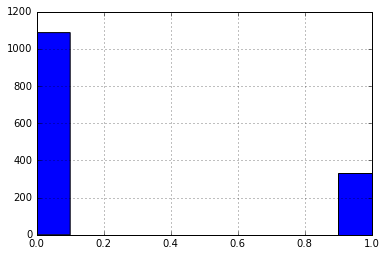

In [21]:
crowdstorming_df_num['BinaryColorClass'].hist()

In [22]:
len(crowdstorming_df_num[crowdstorming_df_num['BinaryColorClass']==1])/len(crowdstorming_df_num)

0.23288637967537051

So, there is only 23% of black people among all people.

In [23]:
crowdstorming_df_num['BinaryColorClass'].value_counts()

0    1087
1     330
Name: BinaryColorClass, dtype: int64

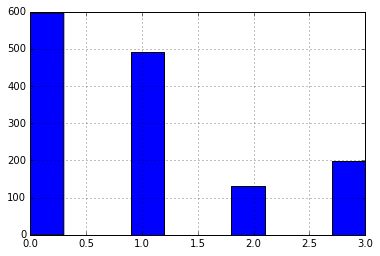

In [24]:
crowdstorming_df_num['MultiColorClass'].hist()

In [25]:
crowdstorming_df_num['MultiColorClass'].value_counts()

0    596
1    491
3    199
2    131
Name: MultiColorClass, dtype: int64

Based on this analysis, the classes we assigned turns out to be unbalanced . To mitigate this issue, there are two different strategies we can opt for: 
* Using different metrics, especially area under curve.
* Rebalancing the sample using weights passed to the model parameters.

Before we do any feature selection, we start by feeding all features into the classifier. Later on when we do plot feature importance and using our own assumptions, we will select features and discuss how well the features importance matches our assumptions of the data.  

In [26]:
# The set of features used
features_all = ['weight', 'nExp', 'height', 'meanExp', 'yellowReds',
       'leagueCountry', 'club', 'victories', 'seExp', 'Alpha_3',
       'yellowCards', 'nIAT', 'birthday', 'goals', 'ties',
       'defeats','games','position', 'redCards', 'meanIAT', 'refCountry', 'refNum', 'seIAT']
# The input dataset
X = crowdstorming_df_num [features_all]
# Binary labels
y_binary = crowdstorming_df_num ['BinaryColorClass']
# Multi-class Labels 
y_multi = crowdstorming_df_num ['MultiColorClass']

# 2. Supervised Learning Using Random Forest

## 2.1. Binary Classification

### Splitting data into train and test

Here we split randomnly the data into training and testing parts by using train_test_split function by assigning 30% to be in the test data. 

In [27]:
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X,y_binary, test_size=0.3)

In [28]:
sample_weights_binary = weight_sample(y_train_binary)

In [29]:
# Fit a random forest to the training data for binary classification, using 100 trees
forest_binary = RandomForestClassifier(class_weight='balanced')

# Passing the training input and labels along with weights vector to train our random forest in balanced mode  
forest_binary = forest_binary.fit(X_train, y_train_binary, sample_weight= sample_weights_binary)

Now before deciding which metrics to use for model evaluation, let's get a rough idea of how our model performs by looking at the confusion matrix and the accuracy. 

#### Confusion matrix and accuracy for training

In [30]:
result_binary_train = forest_binary.predict(X_train)
print('Accuracy Score: ',metrics.accuracy_score(y_train_binary, result_binary_train))

In [31]:
cm=metrics.confusion_matrix(y_train_binary, result_binary_train)
print(cm)

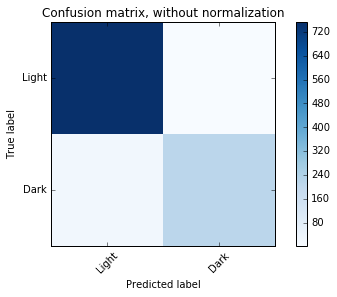

In [32]:
plot_confusion_matrix(cm, classes=['Light','Dark'],
                      title='Confusion matrix, without normalization')

From the confusion matrix above, we can see that the concentration of light people classified as light (true positives) is high and the concentration of dark people classified as dark (true negatives) are high relative to the number of dark people and false positive and false negative are low which means the classifier is doing a good job in predicting the classes.  

#### Confusion Matrix and accuracy for Testing 

In [33]:
result_binary_test = forest_binary.predict(X_test)
print('Accuracy Score: ',metrics.accuracy_score(y_test_binary, result_binary_test))

In [34]:
cm=metrics.confusion_matrix(y_test_binary, result_binary_test)
print(cm)

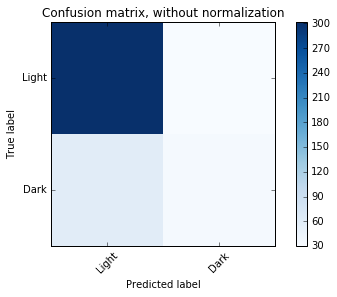

In [35]:
plot_confusion_matrix(cm, classes=['Light','Dark'],
                      title='Confusion matrix, without normalization')

From the confusion matrix above we see that the classifier does a good job in predicting light color skin players but the performance is really poor when it comes to predicting players with dark skin color!

From the results above and since the data is unbalanced, we will not use the accuracy alone, there are two scores that we can use:
* A combination of precision and recall which the f1_score gives us. 
* Area under curve which are insensitive to class balance

#### For Training data:

In [36]:
result_binary_train = forest_binary.predict(X_train)
print('Accuracy Score: ',metrics.accuracy_score(y_train_binary, result_binary_train))
print('Precision Score: ',metrics.precision_score(y_train_binary, result_binary_train))
print('Recall Score: ',metrics.recall_score(y_train_binary, result_binary_train))
print('f1_score: ',metrics.f1_score(y_train_binary, result_binary_train))
print('roc_auc_score: ',metrics.roc_auc_score(y_test_binary, result_binary_test))

#### For Testing data:

In [37]:
result_binary_test = forest_binary.predict(X_test)
print('Accuracy Score: ',metrics.accuracy_score(y_test_binary, result_binary_test))
print('Precision Score: ',metrics.precision_score(y_test_binary, result_binary_test))
print('Recall Score: ',metrics.recall_score(y_test_binary, result_binary_test))
print('f1_score: ',metrics.f1_score(y_test_binary, result_binary_test))
print('roc_auc_score: ',metrics.roc_auc_score(y_test_binary, result_binary_test))

#### K-Fold Cross Validation

We want to get a more exact estimate of the training/testing error, so instead of relying on random splitting we compute the scores over 10 fold cross validated dataset and we take the mean over all the different combinations.

In [38]:
scores_binary_accuracy = cross_val_score(forest_binary,  X, y_binary, cv=10, scoring='accuracy')
scores_binary_f1 = cross_val_score(forest_binary,  X, y_binary, cv=10, scoring='f1')
scores_binary_roc_auc = cross_val_score(forest_binary,  X, y_binary, cv=10, scoring='roc_auc')

print('Accuracy Score: ',scores_binary_accuracy.mean())
print('Precision Score: ',metrics.precision_score(y_test_binary, result_binary_test))
print('Recall Score: ',metrics.recall_score(y_test_binary, result_binary_test))
print('f1_score: ', scores_binary_f1.mean())
print('roc_auc_score: ', scores_binary_roc_auc.mean())

### Trying with Different Parameters and Overfitting:

Here we show how different parameters passed to the Classifier affect the overfitting issue. also we perform cross-validation to mitigate this issue!

In [39]:
forest = RandomForestClassifier(n_estimators=10, max_depth=7)
forest_binary = forest.fit(X_train, y_train_binary) 

result_binary_train = forest_binary.predict(X_train)
print('Training Score')
print('Accuracy Score: ',metrics.accuracy_score(y_train_binary, result_binary_train))
print('f1_score: ',metrics.f1_score(y_train_binary, result_binary_train))
print('roc_auc_score: ',metrics.roc_auc_score(y_test_binary, result_binary_test))

print('------------')

result_binary_test = forest_binary.predict(X_test)
print('Resting Score')
print('Accuracy Score: ',metrics.accuracy_score(y_test_binary, result_binary_test))
print('f1_score: ',metrics.f1_score(y_test_binary, result_binary_test))
print('roc_auc_score: ',metrics.roc_auc_score(y_test_binary, result_binary_test))

In [40]:
forest = RandomForestClassifier(n_estimators=100, max_depth=75)
forest_binary = forest.fit(X_train, y_train_binary) 

result_binary_train = forest_binary.predict(X_train)
print('Training Score')
print('Accuracy Score: ',metrics.accuracy_score(y_train_binary, result_binary_train))
print('f1_score: ',metrics.f1_score(y_train_binary, result_binary_train))
print('roc_auc_score: ',metrics.roc_auc_score(y_test_binary, result_binary_test))

print('------------')

result_binary_test = forest_binary.predict(X_test)
print('Resting Score')
print('Accuracy Score: ',metrics.accuracy_score(y_test_binary, result_binary_test))
print('f1_score: ',metrics.f1_score(y_test_binary, result_binary_test))
print('roc_auc_score: ',metrics.roc_auc_score(y_test_binary, result_binary_test))

From the results above we see that, setting bigger values for n_estimator  and max_depth will lead to a complex model and this leads to overfitting since the gap between the training and the testing score is bigger compared to when we used a simpler model.

Now we perform cross-validation to mitigate this issue!

## Choosing the parameters of the model

Here we use grid search to find the best sets of parameters that give us the maximum value for AUC. We experimented with different values for number of estimators (n_estimators) and maximum depth of the tree (max_depth).

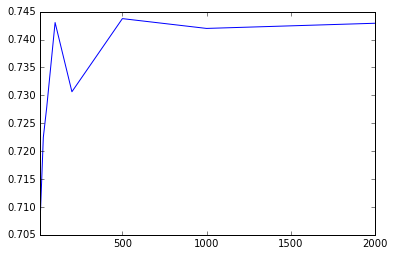

In [41]:
results_roc_auc=[]

n_estimator_options=[10,30,50,100,200,500,1000,2000]

for trees in n_estimator_options:
    model = RandomForestClassifier(n_estimators=trees)
    scores_binary_roc_auc = cross_val_score(model,  X, y_binary, cv=10, scoring='roc_auc')
    print(trees,'trees')

    print('roc_auc score', scores_binary_roc_auc.mean())
    results_roc_auc.append(scores_binary_roc_auc.mean())
    
    print('---------------------')

pd.Series(results_roc_auc, n_estimator_options).plot() 

From the graph above, we conclude that the best score can be achieved when n_estimators is approximately 1000.

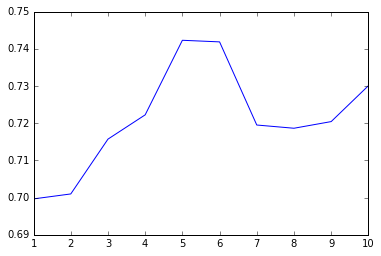

In [42]:
results_roc_auc=[]

max_depth_options=[1,2,3,4,5,6,7,8,9,10]

for max_samples in max_depth_options:
    model = RandomForestClassifier(max_depth=max_samples)
    scores_binary_roc_auc = cross_val_score(model,  X, y_binary, cv=10, scoring='roc_auc')


    print(max_samples,'samples')
    print('roc_auc score', scores_binary_roc_auc.mean())
    results_roc_auc.append(scores_binary_roc_auc.mean())
    
    print('---------------------')
    
pd.Series(results_roc_auc, max_depth_options).plot()



From the graph above, we conclude that we get the best score when max_depth is approximately 5. 

In [43]:
model = RandomForestClassifier(n_estimators=1000, max_depth = 6, class_weight='balanced' )
forest_binary = model.fit(X_train, y_train_binary, sample_weight= sample_weights_binary)
scores_binary = cross_val_score(forest_binary,  X, y_binary, cv=10, scoring='roc_auc')
scores_binary.mean()

0.74541824977604798

### Feature Importance

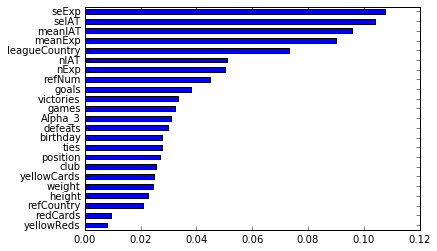

In [44]:
feature_importance= pd.Series(model.feature_importances_,index=X.columns)
feature_importance.sort()
feature_importance.plot(kind='barh')

From the graph above, you can see the features ranked based on their importance. The top features here are seExp, meanExp, leagueCountry and so on.

### Feature Selection

Now, we experiment using a different assumptions on the features that can impact the prediction of the player skin color. We remove the features related to referee since we may think that those features are directly related to the player. 

In [45]:
features_player = ['weight', 'height', 'yellowReds',
       'leagueCountry', 'club', 'victories',
       'yellowCards', 'birthday', 'goals', 'ties',
       'defeats','games','position', 'redCards']

In [46]:
X_2 = crowdstorming_df_num [features_player]
y_binary_2 = crowdstorming_df_num ['BinaryColorClass']
y_multi_2 = crowdstorming_df_num ['MultiColorClass']

X_train_2, X_test_2, y_train_binary_2, y_test_binary_2 = train_test_split(X_2,y_binary_2, test_size=0.3)

model_2 = RandomForestClassifier(n_estimators=1000, max_depth = 6, class_weight='balanced' )
forest_binary_2 = model_2.fit(X_train_2, y_train_binary_2, sample_weight= sample_weights_binary)
scores_binary_2 = cross_val_score(forest_binary_2,  X_2, y_binary_2, cv=10, scoring='roc_auc')
scores_binary_2.mean()

0.69850441211297487

Let us look at the features importance

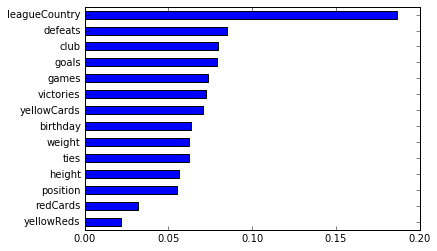

In [47]:
feature_importance= pd.Series(model_2.feature_importances_,index=X_2.columns)
feature_importance.sort()
feature_importance.plot(kind='barh')

By removing referee features, we get lower results for AUC and this is normal since those features rank at the top in feature importance. We observe that by removing referee features, the relative order of importance of player features changes. For example, when we were considering referee features: defeats were more important than goals and weights were more important than birthday, whereas now goals are more important than weights and birthday more important than weights.  

In [48]:
features_player = ['weight', 'height', 'yellowReds',
       'leagueCountry', 'club', 'victories',
       'yellowCards', 'birthday', 'goals', 'ties',
       'defeats','games','position', 'redCards']

## Bonus Part

In this bonus part, we would like to detect parameters for random forest for which we get bias and variance in different sizes of the training and testing dataset. For this, we draw the learning curves using 20 folds cross-validation.

### a. High Variance:

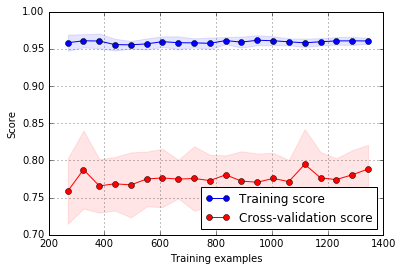

In [49]:
estimator = RandomForestClassifier(n_estimators = 6, max_features = 10)    
plot_learning_curve(estimator,X,y_binary)   

This is an example of high variance (overfitting) since the training score highly exceeds the testing score. We can see that from the gap between the training and testing data (20%) (the curves are away from each other). So, this trained model was overfitted on the training data that it cannot be generalized to the test data which is translated by the relatively low score of the testing compared to the training. 

### b. High Bias

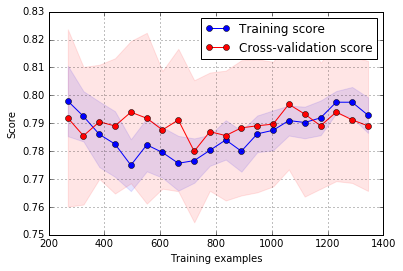

In [50]:
estimator = RandomForestClassifier(max_depth = 2)    
plot_learning_curve(estimator,X,y_binary)   

This is a good example of high bias in which there is very high error for both the training set and the cross-validation set. In this case, the model is too simplistic that it underfits the data and the performance of the classifier is decreased.

## 2.2. Multi-Class Classification

Since the binary classes are highly skewed, we tried to come up with a multi-class configuration that has less skew. We apply the same assumptions as for binary classification and try to compare the accuracy for different approaches. 

### Splitting data into train and test

In [51]:
X_train, X_test, y_train_multi, y_test_multi = train_test_split(X,y_multi, test_size=0.3)

In [52]:
sample_weights_multi = weight_sample(y_train_multi)

In [53]:
# Fit a random forest to the training data for multi-class classification, using 10 trees
forest_multi = RandomForestClassifier(n_estimators=1000, max_depth = 6, class_weight='balanced')

forest_multi = forest_multi.fit(X_train, y_train_multi, sample_weight= sample_weights_binary)

### Model Evaluation using cross validation

In [54]:
result_multi_train = forest_binary.predict(X_train)
result_multi_test = forest_binary.predict(X_test)
scores_multi_accuracy = cross_val_score(forest_multi,  X, y_multi, cv=10, scoring='accuracy')
scores_multi_accuracy.mean()

0.44462789740808917

Compared to the binary case, the accuracy for multi-class classification with more balanced data across classes is lower and this is no better than binary-classification.

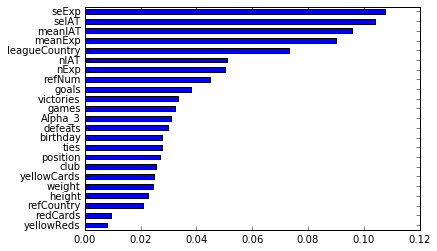

In [55]:
feature_importance= pd.Series(model.feature_importances_,index=X.columns)
feature_importance.sort()
feature_importance.plot(kind='barh')